In [1]:
import os
import torch
from accelerate import Accelerator

from llama2_Model import  llama2_7b_Model_peft
from pep_Dataloader import pep_Dataloader
from pap_Dataloader import pap_Dataloader, get_dataloader, tokenize_text
from evaluation import get_accuracy, get_precision_recall
from datasets import  Dataset

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
! nvidia-smi

Sun Jan 21 18:08:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.01              Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0              12W /  80W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Get model and dataloader

In [3]:
def get_filepath(name,classnum_name,file_name):
    '''
    param name: name of the dataset, pep-3k or pap
    param classnum_name: for pap dataset, binary or multiclass
    param file_name: dev, test, train
    return: the str of apath of the file
    '''
    current_dir =os.path.realpath(".")
    parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
    parent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
    parent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
    if name=='pap':
        filepath=os.path.abspath(os.path.join(parent_dir,'Data',name,'train-dev-test-split-filtered',classnum_name,file_name+'.csv'))
    else:
        filepath=os.path.abspath(os.path.join(parent_dir,'Data',name,'train-dev-test-split',classnum_name,file_name+'.csv'))
    print(filepath)
    return filepath


In [4]:
# Model from Hugging Face hub
base_model= "meta-llama/Llama-2-7b-hf"

filepath1=get_filepath('pep-3k','','train')
filepath2=get_filepath('pep-3k','','dev')
filepath3=get_filepath('pep-3k','','test')


/home/linux1/BOX/modeling23/Data/pep-3k/train-dev-test-split/train.csv
/home/linux1/BOX/modeling23/Data/pep-3k/train-dev-test-split/dev.csv
/home/linux1/BOX/modeling23/Data/pep-3k/train-dev-test-split/test.csv


In [5]:
#model:
llama_model = llama2_7b_Model_peft(base_model)
tokenizer = llama_model.tokenizer

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.59s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original number of parameters: 6607351808
LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (p

In [6]:
# pep3k dataloader
train_dataloader_object=pep_Dataloader(filepath1,tokenizer,3)
eval_dataloader_object=pep_Dataloader(filepath2,tokenizer,'defalut')
test_dataloader_object=pep_Dataloader(filepath3,tokenizer,'defalut')

In [7]:
# pap dataloader
filepath1=get_filepath('pap','binary','train')
filepath2=get_filepath('pap','binary','dev')
filepath3=get_filepath('pap','binary','test')
train_dataloader_object2=pap_Dataloader(filepath1,tokenizer,3)
eval_dataloader_object2=pap_Dataloader(filepath2,tokenizer,'defalut')
test_dataloader_object2=pap_Dataloader(filepath3,tokenizer,'defalut')

/home/linux1/BOX/modeling23/Data/pap/train-dev-test-split-filtered/binary/train.csv
/home/linux1/BOX/modeling23/Data/pap/train-dev-test-split-filtered/binary/dev.csv
/home/linux1/BOX/modeling23/Data/pap/train-dev-test-split-filtered/binary/test.csv
Dataset({
    features: ['text', 'labels'],
    num_rows: 1386
})


Map: 100%|██████████| 1386/1386 [00:00<00:00, 36197.42 examples/s]


Dataset({
    features: ['text', 'labels'],
    num_rows: 173
})


Map: 100%|██████████| 173/173 [00:00<00:00, 17548.12 examples/s]


Dataset({
    features: ['text', 'labels'],
    num_rows: 174
})


Map: 100%|██████████| 174/174 [00:00<00:00, 14858.28 examples/s]


In [8]:
print("train_dataloader_object_pep:",train_dataloader_object.tokenized_dataset)
print("train_dataloader_object_pap:",train_dataloader_object2.tokenized_dataset)
both_dataset =  Dataset.from_dict({
    'text': train_dataloader_object.dataset['text']+train_dataloader_object2.new_dataset['text'],
    'labels': train_dataloader_object.dataset['label']+train_dataloader_object2.new_dataset['labels']
    })
print(both_dataset)
print(len(both_dataset))

train_dataloader_object_pep: Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 2448
})
train_dataloader_object_pap: Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 1386
})
Dataset({
    features: ['text', 'labels'],
    num_rows: 3834
})
3834


In [9]:
both_dataset = tokenize_text(both_dataset, tokenizer)
both_dataloader = get_dataloader(both_dataset, batch_size=3)

Map:   0%|          | 0/3834 [00:00<?, ? examples/s]

Map: 100%|██████████| 3834/3834 [00:00<00:00, 60541.00 examples/s]


In [11]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch.nn as nn
from transformers import get_scheduler

optimizer = AdamW(llama_model.model.parameters(), lr=1e-4 )#5e-5)
loss_fn = nn.CrossEntropyLoss()

accelerator = Accelerator()
both_dataloader, eval_dataloader_pep,test_dataloader_pep, eval_dataloader_pap,test_dataloader_pap ,model, optimizer = accelerator.prepare(
    both_dataloader, eval_dataloader_object.dataloader, test_dataloader_object.dataloader ,
    eval_dataloader_object2.dataloader, test_dataloader_object2.dataloader ,
    llama_model.model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader_object.dataset)

#learning rate adjustment:
lr_scheduler = get_scheduler( 
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


### Check original model with test data

In [12]:
def do_inference(dataloader):
    model.eval()
    with torch.no_grad():
        for labels,text in dataloader:
            logits = model(**text).logits
            the_labels=labels
            get_accuracy(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag='false',flag2='print')

In [13]:
do_inference(test_dataloader_pap)

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Accuracy: 0.477
---positive is plausible
Precision: 0.520
Recall: 0.537
F-score: 0.528
---positive is implausible
Precision: 0.421
Recall: 0.405
F-score: 0.413


In [14]:
do_inference(test_dataloader_pep)

Accuracy: 0.472
---positive is plausible
Precision: 0.467
Recall: 0.418
F-score: 0.441
---positive is implausible
Precision: 0.476
Recall: 0.526
F-score: 0.500


### Train

In [15]:
loss_list=[]
accuracy_list=[]
loss_sum=0
accuracy_sum=0

In [16]:
print(num_epochs)
print(len(both_dataloader))
num_training_steps = num_epochs * len(both_dataloader)
print(num_training_steps)
print(num_training_steps/20)

for thelabels,text in both_dataloader:
    print('thelabels:',thelabels)
    print('text:',text)
    break

3
1278
3834
191.7
thelabels: tensor([0, 0, 0], device='cuda:0')
text: {'input_ids': tensor([[    1,  3677,   298,   688, 12301,     2,     2,     2,     2,     2,
             2,     2,     2],
        [    1,  1701, 29916,  5807,   905, 10435,     2,     2,     2,     2,
             2,     2,     2],
        [    1,  2594,   805,  1144,  8548,     2,     2,     2,     2,     2,
             2,     2,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}


In [17]:
# train
progress_bar = tqdm(range(int(num_training_steps/20)))

flag=0
for epoch in range(num_epochs):
    for thelabels,text in both_dataloader:
        model.train()
        outputs = model(**text)
        logits = outputs.logits
        # print('logits:',logits)
        # print('thelabels:',thelabels)
        loss = loss_fn(logits.squeeze(), thelabels)
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        flag+=1

        loss_sum += int(loss.item())
        a=get_accuracy(logits, thelabels)
        accuracy_sum+=a

        if flag%20==0:
            print(flag,'loss:,',loss_sum/flag, 'accuarcy:',accuracy_sum/flag)
            loss_list.append(loss_sum/flag)
            accuracy_list.append(accuracy_sum/flag)
            progress_bar.update(1)

  0%|          | 0/191 [00:00<?, ?it/s]/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
  1%|          | 1/191 [01:04<3:23:27, 64.25s/it]

20 loss:, 0.7 accuarcy: 0.4833333333333334


  1%|          | 2/191 [02:08<3:22:31, 64.30s/it]

40 loss:, 0.825 accuarcy: 0.4583333333333336


  2%|▏         | 3/191 [03:12<3:21:27, 64.30s/it]

60 loss:, 0.8333333333333334 accuarcy: 0.42222222222222233


  2%|▏         | 4/191 [04:17<3:20:45, 64.42s/it]

80 loss:, 0.7625 accuarcy: 0.4333333333333333


  3%|▎         | 5/191 [05:22<3:20:55, 64.81s/it]

100 loss:, 0.69 accuarcy: 0.45333333333333337


  3%|▎         | 6/191 [06:27<3:19:49, 64.81s/it]

120 loss:, 0.6083333333333333 accuarcy: 0.4888888888888889


  4%|▎         | 7/191 [07:34<3:20:14, 65.29s/it]

140 loss:, 0.5857142857142857 accuarcy: 0.49285714285714277


  4%|▍         | 8/191 [08:40<3:20:34, 65.76s/it]

160 loss:, 0.5375 accuarcy: 0.5083333333333333


  5%|▍         | 9/191 [09:47<3:20:02, 65.95s/it]

180 loss:, 0.49444444444444446 accuarcy: 0.5185185185185186


  5%|▌         | 10/191 [10:53<3:19:40, 66.19s/it]

200 loss:, 0.465 accuarcy: 0.52


  6%|▌         | 11/191 [12:00<3:18:39, 66.22s/it]

220 loss:, 0.44545454545454544 accuarcy: 0.5287878787878788


  6%|▋         | 12/191 [13:06<3:17:36, 66.24s/it]

240 loss:, 0.42916666666666664 accuarcy: 0.5375000000000001


  7%|▋         | 13/191 [14:13<3:16:46, 66.33s/it]

260 loss:, 0.40384615384615385 accuarcy: 0.5397435897435895


  7%|▋         | 14/191 [15:20<3:16:19, 66.55s/it]

280 loss:, 0.37857142857142856 accuarcy: 0.5440476190476187


  8%|▊         | 15/191 [16:27<3:15:31, 66.66s/it]

300 loss:, 0.36333333333333334 accuarcy: 0.5522222222222217


  8%|▊         | 16/191 [17:34<3:14:48, 66.79s/it]

320 loss:, 0.340625 accuarcy: 0.5624999999999993


  9%|▉         | 17/191 [18:40<3:13:43, 66.80s/it]

340 loss:, 0.32941176470588235 accuarcy: 0.562745098039215


  9%|▉         | 18/191 [19:47<3:12:19, 66.70s/it]

360 loss:, 0.3111111111111111 accuarcy: 0.567592592592592


 10%|▉         | 19/191 [20:54<3:11:20, 66.75s/it]

380 loss:, 0.29473684210526313 accuarcy: 0.5807017543859642


 10%|█         | 20/191 [22:01<3:10:18, 66.78s/it]

400 loss:, 0.285 accuarcy: 0.5908333333333324


 11%|█         | 21/191 [23:07<3:09:14, 66.79s/it]

420 loss:, 0.2857142857142857 accuarcy: 0.5920634920634912


 12%|█▏        | 22/191 [24:14<3:08:17, 66.85s/it]

440 loss:, 0.2727272727272727 accuarcy: 0.6007575757575749


 12%|█▏        | 23/191 [25:21<3:06:46, 66.70s/it]

460 loss:, 0.26304347826086955 accuarcy: 0.6115942028985499


 13%|█▎        | 24/191 [26:27<3:05:33, 66.67s/it]

480 loss:, 0.25625 accuarcy: 0.6145833333333326


 13%|█▎        | 25/191 [27:33<3:03:49, 66.44s/it]

500 loss:, 0.25 accuarcy: 0.6179999999999995


 14%|█▎        | 26/191 [28:39<3:02:28, 66.35s/it]

520 loss:, 0.24615384615384617 accuarcy: 0.6205128205128204


 14%|█▍        | 27/191 [29:46<3:01:14, 66.31s/it]

540 loss:, 0.24444444444444444 accuarcy: 0.6203703703703706


 15%|█▍        | 28/191 [30:52<2:59:54, 66.22s/it]

560 loss:, 0.2357142857142857 accuarcy: 0.6285714285714289


 15%|█▌        | 29/191 [31:58<2:58:54, 66.26s/it]

580 loss:, 0.2293103448275862 accuarcy: 0.6339080459770121


 16%|█▌        | 30/191 [33:04<2:57:36, 66.19s/it]

600 loss:, 0.22833333333333333 accuarcy: 0.6361111111111121


 16%|█▌        | 31/191 [34:10<2:56:33, 66.21s/it]

620 loss:, 0.22741935483870968 accuarcy: 0.6392473118279579


 17%|█▋        | 32/191 [35:17<2:55:31, 66.23s/it]

640 loss:, 0.221875 accuarcy: 0.6442708333333342


 17%|█▋        | 33/191 [36:23<2:54:18, 66.19s/it]

660 loss:, 0.21818181818181817 accuarcy: 0.6449494949494959


 18%|█▊        | 34/191 [37:28<2:52:37, 65.97s/it]

680 loss:, 0.21470588235294116 accuarcy: 0.6455882352941187


 18%|█▊        | 35/191 [38:34<2:51:36, 66.00s/it]

700 loss:, 0.20857142857142857 accuarcy: 0.6504761904761915


 19%|█▉        | 36/191 [39:39<2:49:23, 65.57s/it]

720 loss:, 0.20694444444444443 accuarcy: 0.652314814814816


 19%|█▉        | 37/191 [40:43<2:47:30, 65.26s/it]

740 loss:, 0.20270270270270271 accuarcy: 0.656756756756758


 20%|█▉        | 38/191 [41:47<2:45:31, 64.91s/it]

760 loss:, 0.2013157894736842 accuarcy: 0.6600877192982469


 20%|██        | 39/191 [42:52<2:43:50, 64.68s/it]

780 loss:, 0.1987179487179487 accuarcy: 0.6619658119658135


 21%|██        | 40/191 [43:56<2:42:23, 64.53s/it]

800 loss:, 0.19375 accuarcy: 0.6662500000000011


 21%|██▏       | 41/191 [45:01<2:41:53, 64.76s/it]

820 loss:, 0.19146341463414634 accuarcy: 0.6686991869918709


 22%|██▏       | 42/191 [46:06<2:41:08, 64.89s/it]

840 loss:, 0.18928571428571428 accuarcy: 0.6718253968253975


 23%|██▎       | 43/191 [47:12<2:40:24, 65.03s/it]

860 loss:, 0.1872093023255814 accuarcy: 0.6732558139534887


 23%|██▎       | 44/191 [48:17<2:39:26, 65.08s/it]

880 loss:, 0.18409090909090908 accuarcy: 0.6753787878787878


 24%|██▎       | 45/191 [49:23<2:39:04, 65.37s/it]

900 loss:, 0.18222222222222223 accuarcy: 0.6781481481481478


 24%|██▍       | 46/191 [50:28<2:37:55, 65.35s/it]

920 loss:, 0.1782608695652174 accuarcy: 0.6826086956521734


 25%|██▍       | 47/191 [51:33<2:36:35, 65.25s/it]

940 loss:, 0.17659574468085107 accuarcy: 0.6851063829787228


 25%|██▌       | 48/191 [52:39<2:36:02, 65.48s/it]

960 loss:, 0.17395833333333333 accuarcy: 0.6871527777777768


 26%|██▌       | 49/191 [53:44<2:34:25, 65.25s/it]

980 loss:, 0.17142857142857143 accuarcy: 0.6897959183673458


 26%|██▌       | 50/191 [54:48<2:32:29, 64.89s/it]

1000 loss:, 0.169 accuarcy: 0.6923333333333319


 27%|██▋       | 51/191 [55:52<2:31:00, 64.72s/it]

1020 loss:, 0.1676470588235294 accuarcy: 0.6941176470588218


 27%|██▋       | 52/191 [56:56<2:29:27, 64.51s/it]

1040 loss:, 0.1673076923076923 accuarcy: 0.6951923076923059


 28%|██▊       | 53/191 [58:01<2:28:38, 64.63s/it]

1060 loss:, 0.1650943396226415 accuarcy: 0.697798742138363


 28%|██▊       | 54/191 [59:05<2:27:16, 64.50s/it]

1080 loss:, 0.1638888888888889 accuarcy: 0.6993827160493807


 29%|██▉       | 55/191 [1:00:10<2:26:17, 64.54s/it]

1100 loss:, 0.1618181818181818 accuarcy: 0.7015151515151494


 29%|██▉       | 56/191 [1:01:14<2:24:41, 64.31s/it]

1120 loss:, 0.15982142857142856 accuarcy: 0.7044642857142835


 30%|██▉       | 57/191 [1:02:18<2:23:23, 64.21s/it]

1140 loss:, 0.15789473684210525 accuarcy: 0.7055555555555533


 30%|███       | 58/191 [1:03:21<2:21:47, 63.96s/it]

1160 loss:, 0.15689655172413794 accuarcy: 0.708045977011492


 31%|███       | 59/191 [1:04:25<2:20:27, 63.85s/it]

1180 loss:, 0.15423728813559323 accuarcy: 0.7101694915254211


 31%|███▏      | 60/191 [1:05:28<2:19:08, 63.73s/it]

1200 loss:, 0.155 accuarcy: 0.7099999999999973


 32%|███▏      | 61/191 [1:06:32<2:17:56, 63.67s/it]

1220 loss:, 0.15327868852459017 accuarcy: 0.7109289617486312


 32%|███▏      | 62/191 [1:07:35<2:16:49, 63.64s/it]

1240 loss:, 0.1532258064516129 accuarcy: 0.7126344086021479


 33%|███▎      | 63/191 [1:08:39<2:16:03, 63.78s/it]

1260 loss:, 0.15079365079365079 accuarcy: 0.7150793650793622


 34%|███▎      | 64/191 [1:09:43<2:15:09, 63.85s/it]

1280 loss:, 0.14921875 accuarcy: 0.7166666666666636


 34%|███▍      | 65/191 [1:10:47<2:14:09, 63.88s/it]

1300 loss:, 0.1476923076923077 accuarcy: 0.7199999999999969


 35%|███▍      | 66/191 [1:11:51<2:12:59, 63.84s/it]

1320 loss:, 0.14545454545454545 accuarcy: 0.7227272727272694


 35%|███▌      | 67/191 [1:12:55<2:11:47, 63.77s/it]

1340 loss:, 0.14328358208955225 accuarcy: 0.7253731343283548


 36%|███▌      | 68/191 [1:13:58<2:10:46, 63.79s/it]

1360 loss:, 0.1426470588235294 accuarcy: 0.7272058823529377


 36%|███▌      | 69/191 [1:15:03<2:09:51, 63.86s/it]

1380 loss:, 0.14130434782608695 accuarcy: 0.7294685990338129


 37%|███▋      | 70/191 [1:16:07<2:08:59, 63.97s/it]

1400 loss:, 0.14 accuarcy: 0.730714285714282


 37%|███▋      | 71/191 [1:17:11<2:08:07, 64.07s/it]

1420 loss:, 0.1387323943661972 accuarcy: 0.7323943661971796


 38%|███▊      | 72/191 [1:18:15<2:07:08, 64.10s/it]

1440 loss:, 0.1375 accuarcy: 0.7337962962962932


 38%|███▊      | 73/191 [1:19:19<2:06:00, 64.07s/it]

1460 loss:, 0.13561643835616438 accuarcy: 0.7356164383561615


 39%|███▊      | 74/191 [1:20:24<2:05:13, 64.22s/it]

1480 loss:, 0.13445945945945945 accuarcy: 0.7369369369369344


 39%|███▉      | 75/191 [1:21:28<2:04:23, 64.34s/it]

1500 loss:, 0.13333333333333333 accuarcy: 0.7395555555555532


 40%|███▉      | 76/191 [1:22:32<2:02:59, 64.17s/it]

1520 loss:, 0.13157894736842105 accuarcy: 0.7416666666666644


 40%|████      | 77/191 [1:23:36<2:01:51, 64.13s/it]

1540 loss:, 0.1305194805194805 accuarcy: 0.7424242424242404


 41%|████      | 78/191 [1:24:40<2:00:45, 64.12s/it]

1560 loss:, 0.13012820512820514 accuarcy: 0.7438034188034172


 41%|████▏     | 79/191 [1:25:44<1:59:25, 63.98s/it]

1580 loss:, 0.1291139240506329 accuarcy: 0.745358649789028


 42%|████▏     | 80/191 [1:26:49<1:58:56, 64.30s/it]

1600 loss:, 0.128125 accuarcy: 0.7468749999999988


 42%|████▏     | 81/191 [1:27:53<1:57:52, 64.29s/it]

1620 loss:, 0.12777777777777777 accuarcy: 0.7485596707818921


 43%|████▎     | 82/191 [1:28:57<1:56:34, 64.17s/it]

1640 loss:, 0.12682926829268293 accuarcy: 0.7508130081300806


 43%|████▎     | 83/191 [1:30:02<1:55:36, 64.22s/it]

1660 loss:, 0.12530120481927712 accuarcy: 0.7528112449799191


 44%|████▍     | 84/191 [1:31:05<1:54:20, 64.12s/it]

1680 loss:, 0.1255952380952381 accuarcy: 0.7537698412698409


 45%|████▍     | 85/191 [1:32:10<1:53:22, 64.17s/it]

1700 loss:, 0.12411764705882353 accuarcy: 0.7558823529411763


 45%|████▌     | 86/191 [1:33:14<1:52:08, 64.08s/it]

1720 loss:, 0.12325581395348838 accuarcy: 0.757751937984496


 46%|████▌     | 87/191 [1:34:18<1:51:06, 64.10s/it]

1740 loss:, 0.12298850574712644 accuarcy: 0.7593869731800768


 46%|████▌     | 88/191 [1:35:23<1:50:29, 64.37s/it]

1760 loss:, 0.1215909090909091 accuarcy: 0.7607954545454548


 47%|████▋     | 89/191 [1:36:29<1:50:39, 65.09s/it]

1780 loss:, 0.12134831460674157 accuarcy: 0.7616104868913862


 47%|████▋     | 90/191 [1:37:36<1:50:26, 65.61s/it]

1800 loss:, 0.12 accuarcy: 0.7625925925925934


 48%|████▊     | 91/191 [1:38:42<1:49:27, 65.68s/it]

1820 loss:, 0.11868131868131868 accuarcy: 0.7644688644688654


 48%|████▊     | 92/191 [1:39:48<1:48:38, 65.84s/it]

1840 loss:, 0.11793478260869565 accuarcy: 0.7653985507246389


 49%|████▊     | 93/191 [1:40:55<1:48:05, 66.18s/it]

1860 loss:, 0.11666666666666667 accuarcy: 0.7670250896057361


 49%|████▉     | 94/191 [1:42:01<1:46:43, 66.02s/it]

1880 loss:, 0.11648936170212766 accuarcy: 0.7682624113475194


 50%|████▉     | 95/191 [1:43:06<1:44:57, 65.60s/it]

1900 loss:, 0.11578947368421053 accuarcy: 0.7694736842105282


 50%|█████     | 96/191 [1:44:11<1:43:39, 65.47s/it]

1920 loss:, 0.11458333333333333 accuarcy: 0.7704861111111133


 51%|█████     | 97/191 [1:45:17<1:42:43, 65.57s/it]

1940 loss:, 0.1134020618556701 accuarcy: 0.7721649484536106


 51%|█████▏    | 98/191 [1:46:22<1:41:38, 65.57s/it]

1960 loss:, 0.11326530612244898 accuarcy: 0.7736394557823154


 52%|█████▏    | 99/191 [1:47:29<1:41:00, 65.88s/it]

1980 loss:, 0.11313131313131314 accuarcy: 0.7750841750841776


 52%|█████▏    | 100/191 [1:48:34<1:39:39, 65.71s/it]

2000 loss:, 0.112 accuarcy: 0.7761666666666694


 53%|█████▎    | 101/191 [1:49:40<1:38:28, 65.65s/it]

2020 loss:, 0.11089108910891089 accuarcy: 0.77706270627063


 53%|█████▎    | 102/191 [1:50:46<1:37:33, 65.77s/it]

2040 loss:, 0.11078431372549019 accuarcy: 0.7776143790849704


 54%|█████▍    | 103/191 [1:51:53<1:36:59, 66.13s/it]

2060 loss:, 0.11019417475728155 accuarcy: 0.7784789644012977


 54%|█████▍    | 104/191 [1:52:59<1:35:49, 66.09s/it]

2080 loss:, 0.10961538461538461 accuarcy: 0.779967948717952


 55%|█████▍    | 105/191 [1:54:04<1:34:15, 65.76s/it]

2100 loss:, 0.10904761904761905 accuarcy: 0.7795238095238132


 55%|█████▌    | 106/191 [1:55:09<1:32:59, 65.64s/it]

2120 loss:, 0.1080188679245283 accuarcy: 0.780503144654092


 56%|█████▌    | 107/191 [1:56:14<1:31:42, 65.50s/it]

2140 loss:, 0.10747663551401869 accuarcy: 0.7814641744548327


 57%|█████▋    | 108/191 [1:57:20<1:30:55, 65.73s/it]

2160 loss:, 0.10648148148148148 accuarcy: 0.782561728395066


 57%|█████▋    | 109/191 [1:58:25<1:29:23, 65.41s/it]

2180 loss:, 0.10550458715596331 accuarcy: 0.7839449541284448


 58%|█████▊    | 110/191 [1:59:30<1:28:00, 65.19s/it]

2200 loss:, 0.10545454545454545 accuarcy: 0.7850000000000045


 58%|█████▊    | 111/191 [2:00:34<1:26:40, 65.00s/it]

2220 loss:, 0.1045045045045045 accuarcy: 0.7866366366366411


 59%|█████▊    | 112/191 [2:01:39<1:25:21, 64.83s/it]

2240 loss:, 0.10357142857142858 accuarcy: 0.7877976190476237


 59%|█████▉    | 113/191 [2:02:43<1:24:14, 64.81s/it]

2260 loss:, 0.10265486725663717 accuarcy: 0.7889380530973499


 60%|█████▉    | 114/191 [2:03:48<1:23:15, 64.88s/it]

2280 loss:, 0.10219298245614035 accuarcy: 0.7903508771929872


 60%|██████    | 115/191 [2:04:55<1:22:43, 65.31s/it]

2300 loss:, 0.10173913043478261 accuarcy: 0.7918840579710194


 61%|██████    | 116/191 [2:06:00<1:21:30, 65.20s/it]

2320 loss:, 0.10172413793103448 accuarcy: 0.7923850574712693


 61%|██████▏   | 117/191 [2:07:04<1:20:07, 64.97s/it]

2340 loss:, 0.10170940170940171 accuarcy: 0.792877492877498


 62%|██████▏   | 118/191 [2:08:09<1:19:04, 65.00s/it]

2360 loss:, 0.10127118644067797 accuarcy: 0.7940677966101747


 62%|██████▏   | 119/191 [2:09:14<1:17:47, 64.83s/it]

2380 loss:, 0.1004201680672269 accuarcy: 0.7943977591036467


 63%|██████▎   | 120/191 [2:10:18<1:16:32, 64.68s/it]

2400 loss:, 0.10041666666666667 accuarcy: 0.7950000000000054


 63%|██████▎   | 121/191 [2:11:23<1:15:26, 64.66s/it]

2420 loss:, 0.10041322314049586 accuarcy: 0.795730027548215


 64%|██████▍   | 122/191 [2:12:28<1:14:27, 64.75s/it]

2440 loss:, 0.09959016393442623 accuarcy: 0.7965846994535576


 64%|██████▍   | 123/191 [2:13:32<1:13:23, 64.76s/it]

2460 loss:, 0.0991869918699187 accuarcy: 0.7978319783197889


 65%|██████▍   | 124/191 [2:14:38<1:12:33, 64.99s/it]

2480 loss:, 0.09879032258064516 accuarcy: 0.7981182795698984


 65%|██████▌   | 125/191 [2:15:43<1:11:40, 65.15s/it]

2500 loss:, 0.098 accuarcy: 0.799200000000006


 66%|██████▌   | 126/191 [2:16:49<1:10:41, 65.26s/it]

2520 loss:, 0.09761904761904762 accuarcy: 0.8002645502645563


 66%|██████▋   | 127/191 [2:17:55<1:09:49, 65.47s/it]

2540 loss:, 0.09763779527559055 accuarcy: 0.8005249343832084


 67%|██████▋   | 128/191 [2:19:01<1:08:58, 65.69s/it]

2560 loss:, 0.09765625 accuarcy: 0.801432291666673


 68%|██████▊   | 129/191 [2:20:07<1:07:52, 65.69s/it]

2580 loss:, 0.09689922480620156 accuarcy: 0.8027131782945798


 68%|██████▊   | 130/191 [2:21:12<1:06:45, 65.67s/it]

2600 loss:, 0.09653846153846155 accuarcy: 0.8034615384615444


 69%|██████▊   | 131/191 [2:22:19<1:05:58, 65.97s/it]

2620 loss:, 0.09580152671755725 accuarcy: 0.804452926208657


 69%|██████▉   | 132/191 [2:23:28<1:05:38, 66.75s/it]

2640 loss:, 0.09507575757575758 accuarcy: 0.8059343434343491


 70%|██████▉   | 133/191 [2:24:33<1:04:15, 66.48s/it]

2660 loss:, 0.0943609022556391 accuarcy: 0.8071428571428626


 70%|███████   | 134/191 [2:25:39<1:02:51, 66.16s/it]

2680 loss:, 0.09365671641791044 accuarcy: 0.8079601990049803


 71%|███████   | 135/191 [2:26:45<1:01:35, 66.00s/it]

2700 loss:, 0.09296296296296297 accuarcy: 0.8092592592592643


 71%|███████   | 136/191 [2:27:50<1:00:25, 65.93s/it]

2720 loss:, 0.09264705882352942 accuarcy: 0.8102941176470638


 72%|███████▏  | 137/191 [2:28:57<59:29, 66.10s/it]  

2740 loss:, 0.09197080291970802 accuarcy: 0.8114355231143601


 72%|███████▏  | 138/191 [2:30:03<58:23, 66.11s/it]

2760 loss:, 0.09130434782608696 accuarcy: 0.8125603864734346


 73%|███████▎  | 139/191 [2:31:08<57:06, 65.89s/it]

2780 loss:, 0.09064748201438849 accuarcy: 0.8134292565947286


 73%|███████▎  | 140/191 [2:32:14<56:00, 65.90s/it]

2800 loss:, 0.09035714285714286 accuarcy: 0.8142857142857185


 74%|███████▍  | 141/191 [2:33:18<54:30, 65.40s/it]

2820 loss:, 0.0897163120567376 accuarcy: 0.8154846335697441


 74%|███████▍  | 142/191 [2:34:24<53:21, 65.35s/it]

2840 loss:, 0.08908450704225353 accuarcy: 0.8161971830985953


 75%|███████▍  | 143/191 [2:35:29<52:19, 65.41s/it]

2860 loss:, 0.08846153846153847 accuarcy: 0.8172494172494209


 75%|███████▌  | 144/191 [2:36:34<51:06, 65.25s/it]

2880 loss:, 0.08854166666666667 accuarcy: 0.818055555555559


 76%|███████▌  | 145/191 [2:37:39<49:55, 65.11s/it]

2900 loss:, 0.08793103448275862 accuarcy: 0.8189655172413826


 76%|███████▋  | 146/191 [2:38:43<48:37, 64.84s/it]

2920 loss:, 0.08767123287671233 accuarcy: 0.8197488584474917


 77%|███████▋  | 147/191 [2:39:47<47:20, 64.55s/it]

2940 loss:, 0.08707482993197278 accuarcy: 0.8209750566893455


 77%|███████▋  | 148/191 [2:40:51<46:12, 64.48s/it]

2960 loss:, 0.08648648648648649 accuarcy: 0.8218468468468497


 78%|███████▊  | 149/191 [2:41:55<45:03, 64.37s/it]

2980 loss:, 0.08590604026845637 accuarcy: 0.823042505592844


 79%|███████▊  | 150/191 [2:43:00<44:01, 64.43s/it]

3000 loss:, 0.08566666666666667 accuarcy: 0.8235555555555583


 79%|███████▉  | 151/191 [2:44:04<42:55, 64.39s/it]

3020 loss:, 0.08509933774834437 accuarcy: 0.8245033112582807


 80%|███████▉  | 152/191 [2:45:09<41:49, 64.36s/it]

3040 loss:, 0.08453947368421053 accuarcy: 0.8254385964912305


 80%|████████  | 153/191 [2:46:13<40:44, 64.34s/it]

3060 loss:, 0.08398692810457517 accuarcy: 0.8265795206971702


 81%|████████  | 154/191 [2:47:17<39:42, 64.40s/it]

3080 loss:, 0.08376623376623377 accuarcy: 0.827597402597405


 81%|████████  | 155/191 [2:48:23<38:53, 64.82s/it]

3100 loss:, 0.0832258064516129 accuarcy: 0.8282795698924753


 82%|████████▏ | 156/191 [2:49:29<37:55, 65.03s/it]

3120 loss:, 0.08269230769230769 accuarcy: 0.8291666666666687


 82%|████████▏ | 157/191 [2:50:33<36:43, 64.80s/it]

3140 loss:, 0.0821656050955414 accuarcy: 0.8300424628450126


 83%|████████▎ | 158/191 [2:51:38<35:43, 64.97s/it]

3160 loss:, 0.08164556962025317 accuarcy: 0.8309071729957824


 83%|████████▎ | 159/191 [2:52:44<34:47, 65.23s/it]

3180 loss:, 0.08144654088050314 accuarcy: 0.831865828092245


 84%|████████▍ | 160/191 [2:53:51<34:00, 65.81s/it]

3200 loss:, 0.08125 accuarcy: 0.8328125000000017


 84%|████████▍ | 161/191 [2:54:57<32:53, 65.80s/it]

3220 loss:, 0.08074534161490683 accuarcy: 0.8336438923395462


 85%|████████▍ | 162/191 [2:56:02<31:38, 65.46s/it]

3240 loss:, 0.08024691358024691 accuarcy: 0.8343621399176969


 85%|████████▌ | 163/191 [2:57:07<30:28, 65.29s/it]

3260 loss:, 0.07975460122699386 accuarcy: 0.8351738241308807


 86%|████████▌ | 164/191 [2:58:11<29:11, 64.86s/it]

3280 loss:, 0.07926829268292683 accuarcy: 0.8357723577235784


 86%|████████▋ | 165/191 [2:59:14<27:58, 64.57s/it]

3300 loss:, 0.07878787878787878 accuarcy: 0.8367676767676779


 87%|████████▋ | 166/191 [3:00:21<27:06, 65.05s/it]

3320 loss:, 0.0786144578313253 accuarcy: 0.8374497991967882


 87%|████████▋ | 167/191 [3:01:26<26:06, 65.25s/it]

3340 loss:, 0.0784431137724551 accuarcy: 0.8382235528942125


 88%|████████▊ | 168/191 [3:02:33<25:11, 65.73s/it]

3360 loss:, 0.07857142857142857 accuarcy: 0.8388888888888897


 88%|████████▊ | 169/191 [3:03:38<24:02, 65.58s/it]

3380 loss:, 0.07869822485207101 accuarcy: 0.8394477317554246


 89%|████████▉ | 170/191 [3:04:44<22:59, 65.69s/it]

3400 loss:, 0.07823529411764706 accuarcy: 0.8403921568627457


 90%|████████▉ | 171/191 [3:05:50<21:52, 65.64s/it]

3420 loss:, 0.07777777777777778 accuarcy: 0.8412280701754391


 90%|█████████ | 172/191 [3:06:55<20:45, 65.56s/it]

3440 loss:, 0.07732558139534884 accuarcy: 0.842054263565892


 91%|█████████ | 173/191 [3:08:01<19:40, 65.56s/it]

3460 loss:, 0.07687861271676301 accuarcy: 0.8428709055876691


 91%|█████████ | 174/191 [3:09:06<18:31, 65.41s/it]

3480 loss:, 0.0764367816091954 accuarcy: 0.8435823754789276


 92%|█████████▏| 175/191 [3:10:11<17:26, 65.40s/it]

3500 loss:, 0.076 accuarcy: 0.8440952380952382


 92%|█████████▏| 176/191 [3:11:16<16:18, 65.26s/it]

3520 loss:, 0.07613636363636364 accuarcy: 0.8446969696969697


 93%|█████████▎| 177/191 [3:12:21<15:10, 65.05s/it]

3540 loss:, 0.07570621468926554 accuarcy: 0.8453860640301318


 93%|█████████▎| 178/191 [3:13:25<14:03, 64.92s/it]

3560 loss:, 0.07528089887640449 accuarcy: 0.8459737827715356


 94%|█████████▎| 179/191 [3:14:30<12:57, 64.83s/it]

3580 loss:, 0.07541899441340782 accuarcy: 0.8465549348230912


 94%|█████████▍| 180/191 [3:15:35<11:54, 64.92s/it]

3600 loss:, 0.075 accuarcy: 0.8474074074074074


 95%|█████████▍| 181/191 [3:16:41<10:51, 65.14s/it]

3620 loss:, 0.07458563535911603 accuarcy: 0.8479742173112337


 95%|█████████▌| 182/191 [3:17:47<09:48, 65.36s/it]

3640 loss:, 0.07417582417582418 accuarcy: 0.8485347985347983


 96%|█████████▌| 183/191 [3:18:52<08:42, 65.26s/it]

3660 loss:, 0.07377049180327869 accuarcy: 0.8489981785063749


 96%|█████████▋| 184/191 [3:19:58<07:38, 65.44s/it]

3680 loss:, 0.07336956521739131 accuarcy: 0.8495471014492749


 97%|█████████▋| 185/191 [3:21:02<06:30, 65.12s/it]

3700 loss:, 0.07351351351351351 accuarcy: 0.8500900900900895


 97%|█████████▋| 186/191 [3:22:07<05:24, 64.97s/it]

3720 loss:, 0.07311827956989247 accuarcy: 0.8507168458781356


 98%|█████████▊| 187/191 [3:23:11<04:19, 64.94s/it]

3740 loss:, 0.07272727272727272 accuarcy: 0.8512477718360063


 98%|█████████▊| 188/191 [3:24:16<03:14, 64.86s/it]

3760 loss:, 0.07234042553191489 accuarcy: 0.8518617021276588


 99%|█████████▉| 189/191 [3:25:21<02:09, 64.78s/it]

3780 loss:, 0.07222222222222222 accuarcy: 0.8523809523809515


 99%|█████████▉| 190/191 [3:26:25<01:04, 64.79s/it]

3800 loss:, 0.07236842105263158 accuarcy: 0.8528947368421042


100%|██████████| 191/191 [3:27:31<00:00, 64.87s/it]

3820 loss:, 0.07198952879581152 accuarcy: 0.8536649214659675


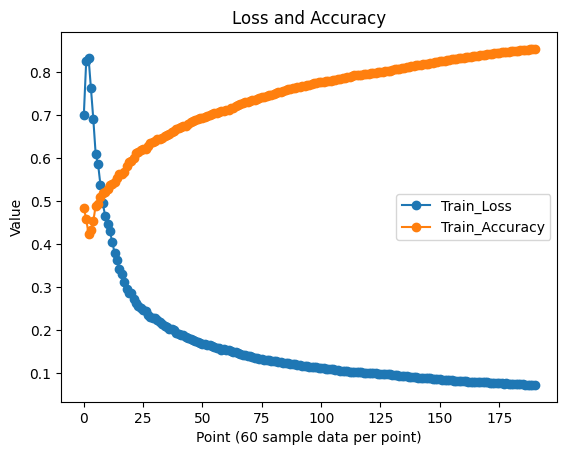

In [19]:
# print(loss_list)
# print(accuracy_list)

import matplotlib.pyplot as plt

# Plotting the data
plt.plot(loss_list, label='Train_Loss', marker='o')
plt.plot(accuracy_list, label='Train_Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Point (60 sample data per point)')
plt.ylabel('Value')
plt.title('Loss and Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [20]:
do_inference(test_dataloader_pap)

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Accuracy: 0.862
---positive is plausible
Precision: 0.874
Recall: 0.874
F-score: 0.874
---positive is implausible
Precision: 0.848
Recall: 0.848
F-score: 0.848


In [21]:
do_inference(test_dataloader_pep)

Accuracy: 0.886
---positive is plausible
Precision: 0.888
Recall: 0.882
F-score: 0.885
---positive is implausible
Precision: 0.884
Recall: 0.890
F-score: 0.887


### for wrong prediction analysis, save the results to a file:

In [24]:
import numpy as np
def do_inference_analysis(dataloader):
    model.eval()
    text_list=[]
    with torch.no_grad():
        for labels,text in dataloader:
            text_ids=text['input_ids']
            for j in range(len(text_ids)):
                the_text=tokenizer.decode(text_ids[j], skip_special_tokens=True)
                text_list.append(the_text)
            logits = model(**text).logits
            the_labels=labels
            get_accuracy(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag2='print')
            get_precision_recall(logits, the_labels,flag='false',flag2='print')
            preds_up=logits.detach().cpu().numpy()
            preds = np.array([ i.argmax() for i in preds_up ])
            the_labels = np.array(the_labels.cpu())
    return text_list, preds,the_labels

In [25]:
text_list, preds,the_labels = do_inference_analysis(test_dataloader_pap)

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Accuracy: 0.862
---positive is plausible
Precision: 0.874
Recall: 0.874
F-score: 0.874
---positive is implausible
Precision: 0.848
Recall: 0.848
F-score: 0.848


In [27]:
text_list_pap=text_list
dict_pap={}
for i in range(len(text_list)):
    the_text=text_list_pap[i]
    dict_pap[the_text]={'preds':preds[i],'original_labels':the_labels[i]}
with open('pap_preds.txt', 'w') as file:
    file.write(str(dict_pap))

In [28]:
text_list2, preds2,the_labels2 = do_inference_analysis(test_dataloader_pep)
text_list_pep=text_list2
dict_pep={}
for i in range(len(text_list2)):
    the_text=text_list_pep[i]
    dict_pep[the_text]={'preds':preds2[i],'original_labels':the_labels2[i]}
with open('pep3k_preds.txt', 'w') as file:
    file.write(str(dict_pep))

/home/linux1/miniconda3/envs/llama2pep/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Accuracy: 0.886
---positive is plausible
Precision: 0.888
Recall: 0.882
F-score: 0.885
---positive is implausible
Precision: 0.884
Recall: 0.890
F-score: 0.887


: 

In [ ]:
save_dir= "./after_finetuned_llama2_7B_un_merge"
model.save_pretrained(save_dir,safe_safetensors=True)
save_dir_tokenizer= save_dir+"/tokenizer"
tokenizer.save_pretrained(save_dir_tokenizer)

('./after_finetuned_llama2_7B_un_merge/tokenizer/tokenizer_config.json',
 './after_finetuned_llama2_7B_un_merge/tokenizer/special_tokens_map.json',
 './after_finetuned_llama2_7B_un_merge/tokenizer/tokenizer.model',
 './after_finetuned_llama2_7B_un_merge/tokenizer/added_tokens.json',
 './after_finetuned_llama2_7B_un_merge/tokenizer/tokenizer.json')

In [ ]:
#model.merge_and_unload()

##  Problem: Loading the model after saving will encounter problems:
### 1. save model before using model.merge_and_unload() : 
#### Reload success. But after saving and loading the model, the performance is not the same (almost as bad as the original model).
### 2. save model after using model.merge_and_unload(): 
#### Reload fail. Get error: SafetensorError: Error while deserializing header: InvalidHeaderDeserialization

This problem has not been solved yet.